In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation
from nltk.corpus import stopwords
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

corpus = pd.read_csv('story_blog_posts.csv.gz', compression='gzip')
stopwords = stopwords.words("portuguese")

In [37]:
n_features = 2000
n_top_words = 20

In [26]:
def print_top_words(model, feature_names, n_top_words, data):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d Avg(%.5f):" % (topic_idx, data.mean(axis=0)[topic_idx]))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def diff(x): 
    return (x['diario_mean']) - (x['outro_mean'])

In [11]:
from nltk.corpus import floresta
from nltk import DefaultTagger, AffixTagger, UnigramTagger, BigramTagger, TrigramTagger
import nltk 
sent_tokenizer=nltk.data.load('tokenizers/punkt/portuguese.pickle')

#tagged_sents = floresta.tagged_sents()
#t0 = DefaultTagger('H+n') # if word not known, just guess "noun"
#affix_tagger = AffixTagger(tagged_sents, backoff=t0)
#unigram_tagger = UnigramTagger(tagged_sents, cutoff=0, backoff=affix_tagger)
#bigram_tagger = BigramTagger(tagged_sents, cutoff=0, backoff=unigram_tagger)
#trigram_tagger = TrigramTagger(tagged_sents, cutoff=0, backoff=bigram_tagger)

import pickle
#affix_file = open('portuguese_affix_tagger.pickle', 'wb')
#pickle.dump(affix_tagger, affix_file)
#affix_file.close()

#unigram_file = open('portuguese_unigram_tagger.pickle', 'wb')
#pickle.dump(unigram_tagger, unigram_file)
#unigram_file.close()

#bigram_file = open('portuguese_bigram_tagger.pickle', 'wb')
#pickle.dump(bigram_tagger, bigram_file)
#bigram_file.close()

#trigram_file = open('portuguese_trigram_tagger.pickle', 'wb')
#pickle.dump(trigram_tagger, trigram_file)
#trigram_file.close()

In [5]:
with open('portuguese_affix_tagger.pickle', 'rb') as f: affix_tagger = pickle.load(f)
with open('portuguese_unigram_tagger.pickle', 'rb') as f: unigram_tagger = pickle.load(f)
with open('portuguese_bigram_tagger.pickle', 'rb') as f: bigram_tagger = pickle.load(f)
with open('portuguese_trigram_tagger.pickle', 'rb') as f: trigram_tagger = pickle.load(f)

In [ ]:
from nltk import tokenize

def simplify_tag(t):
    if t and "+" in t:
        return t[t.index("+")+1:]
    else:
        return t

def content_words(sentence):
    #Nouns, verbs, adjectives and adverbs 
    tags = trigram_tagger.tag(tokenize.word_tokenize(sentence))
    tags = [(w ,simplify_tag(t)) for (w,t) in tags]

    words = []
    for (word, tag) in tags:
        if tag in ['adv','adj','v-fin','n']:
          words.append(word)

    return ' '.join(words)

sentences = []
for text in corpus.content:
    for sentence in sent_tokenizer.tokenize(text):
        sentences.append(content_words(sentence))

In [64]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, strip_accents='unicode',
                                max_features=n_features,
                                stop_words=stopwords)
tf = tf_vectorizer.fit_transform(sentences)

In [75]:
n_topics = 50
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
data = lda.fit_transform(tf)

In [76]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words, data)

Topic #0 Avg(0.01458):
consegui assunto otimo roupa interessante numero gostaria peguei maximo blogs deste devem tv legais desenho ira querida canal lagrimas le
Topic #1 Avg(0.01841):
blog hora fiquei momento podem chegou video neste imagem leitura conheci cha tirei pagina detalhe lapis ritmo presenca capa comentario
Topic #2 Avg(0.01666):
lado amigos mes diz caminho veio meninas show detalhes voce planos proprio 2012 casal parei fome bracos precisamos meta experiencias
Topic #3 Avg(0.01530):
vontade amiga gostei prova cheiro comida livre louca forno significa anime restaurante doces saudades memoria funciona frango justo et mora
Topic #4 Avg(0.01879):
onde posso atras cheguei usei resultado marca forca exatamente coloquei podemos terra vestido decoracao delicia leva igual km oleo hidratacao
Topic #5 Avg(0.01876):
bom ano novo manha passei palavras comecou deveria ca parede suficiente tema pratica levou culpa mensagem maio abri 2015 correria
Topic #6 Avg(0.01741):
coisas primeiro quise

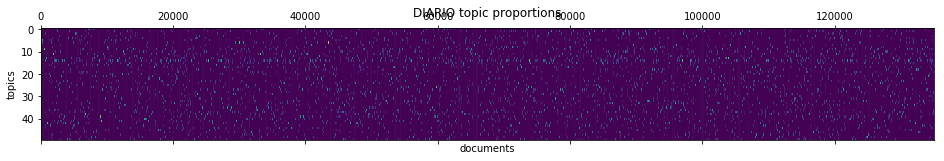

In [77]:
%matplotlib inline

plt.figure()
plt.matshow(np.transpose(data))   
plt.gca().set_aspect('auto')
plt.title('DIARIO topic proportions')
plt.ylabel('topics')
plt.xlabel('documents')
plt.show()

In [73]:
story_liwc = pd.read_csv('story_liwc.csv.gz', compression='gzip')
story_liwc.shape

(134955, 65)

In [74]:
data.shape

(134955, 30)

In [78]:
topics = pd.DataFrame(data, columns=range(0,n_topics), index=story_liwc.index.values)

In [2]:
#result = pd.concat([story_liwc, topics], axis=1)
#result.to_csv('story_liwc_topics.csv.gz', compression='gzip')
result = pd.read_csv('story_liwc_topics.csv.gz', compression='gzip')
result.shape

(134955, 116)

In [89]:
#top 5 topics: 
# Topic #14 Avg(0.05082):
# Topic #37 Avg(0.02903):
# Topic #9 Avg(0.02720):
# Topic #13 Avg(0.02691):
# Topic #15 Avg(0.02506):

In [17]:
sentences = []
for text in corpus.content:
    sentences.extend(sent_tokenizer.tokenize(text))
len(sentences)

134955

In [6]:
def polarity(x):
    return x['posemo'] - x['negemo'] 

result['polarity'] = result.apply(polarity,axis=1)

In [33]:
psychological_columns = ['swear','social','family','friend','humans','bio','body','health','sexual','ingest','relativ','motion','space','time','work','achieve','leisure','home','money','relig','death']
threshold = 0.3
top5_topics = ['14','37','9','13','15']

for Ttopics in top5_topics:
    print("TOPIC: " + str(Ttopics))
    print("-------------")
    for i in range(0,3):
        idx = result.sort_values(Ttopics,ascending=False).head(3).values[i][0]
        print(sentences[int(idx)])
    print("-------------")
    total = len(result[(result[Ttopics] > threshold)])
    pos = len(result[(result[Ttopics] > threshold) & (result['polarity'] > 0)]) / total
    neg = len(result[(result[Ttopics] > threshold) & (result['polarity'] < 0)]) / total
    print("Total: " + str(total) + ", pos: " + str(pos) + ", neg: " + str(neg))
    print("-------------")
    print(result[psychological_columns][(result[Ttopics] > threshold)].mean().sort_values(ascending=False).head(15))
    print("-------------")

TOPIC: 14
-------------
Mas esse post não é um post de reclamação, é um post de reflexão.
Não, não e não.
Não, não e não.
-------------
Total: 5108, pos: 0.2960062646828504, neg: 0.1528974158183242
-------------
social     2.057753
relativ    1.814800
humans     0.734143
space      0.652310
motion     0.635082
bio        0.583399
time       0.550313
swear      0.492365
ingest     0.488841
achieve    0.295810
body       0.268403
money      0.243540
leisure    0.203406
work       0.192052
sexual     0.131363
dtype: float64
-------------
TOPIC: 37
-------------
Will Traynor mudou a vida de Louisa Clark, Louisa Clark mudou a vida de Will Traynor, e os dois mudaram a minha.
Bem, quero deixar bem claro que isso tem mais a ver com a minha vida real, com a minha vida social fora da internet.
Bem, bem melhor.
-------------
Total: 2119, pos: 0.6007550731477111, neg: 0.06370929683813119
-------------
relativ    1.726758
social     1.708353
space      0.736196
bio        0.641340
humans     0.5587